# Introduction

In certain applications of Data Science, one may find themselves needing to produce classification models where the data set provided to them has an extremely significant portion of the data in one classification class. In these situations, the models that are trained on extremely imbalanced datasets can exhibit a very undesirable behavior - only ever predicting the majority class.

While only predicting the majority class would minimize the objective function used to train the model (which is almost always a metric quantifying raw error), it can lead to very dire consequences. Take credit card fraud detection as an example. Nearly all credit card transactions that occur are non-fraudulent, with a very tiny percentage of transactions being fraudulent. In this case, if the classification models that are being built don't take into account the imbalanced nature of the data, they would always predict any new transaction as non-fraudulent. This is obviously highly concerning and would be a major security risk.

This tutorial will introduce methods to mitigate the problems that arise in creating classification models caused by training on imbalanced data.

# Tutorial Content



This tutorial will cover the importance of carefully handling imbalanced data when creating classification models in the following sections:
- [Installing Appropriate Packages](#Installing-Appropriate-Packages)
- [Downloading Data File](#Downloading-Data-File)
- [Explanation of Data](#Explanation-of-Data)
- [Data Modification](#Data-Modification)
- [Train-Test Split and Visualizing Imbalance in Train Data](#Train-Test-Split-and-Visualizing-Imblance-in-Train-Data)
- [Unbalanced Classification Model](#Unbalanced-Classification-Model)
- [Introduction of New Metric: Misclassification Cost](#Introduction-of-New-Metric:-Misclassification-Cost)
- [Balanced Classification Model](#Balanced-Classification-Model)
- [Summary](#Summary)
- [Notes and Assumptions Made](#Notes-and-Assumptions-Made)
- [References/Additional Resources](#References/Additional-Resources)

# Installing Appropriate Packages

This tutorial will be using the imbalanced-learn package. The imbalanced-learn package has the following dependencies:
- python (>=3.6)
    - Problems may arise with python 3.7: if this is the case, please downgrade to python 3.6.x
- numpy (>=1.13.3)
- scipy (>=0.19.1)
- scikit-learn (>=0.23)

Once all the dependencies are verified, you can install imbalanced-learn with the following pip command:

    $ pip install -U imbalanced-learn
    
or the following conda command:

    $ conda install -c conda-forge imbalanced-learn

If you are still experiencing issues installing imbalanced-learn, please refer to the following documentation: https://imbalanced-learn.org/stable/install.html#getting-started 

# Downloading Data File

To download the data file that will be used in the remainder of this tutorial, please click [here](http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data).

Alternatively you may visit the following website: http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/

Click on the bullet point "balance-scale.data" to download the file called "balance-scale.data".

Once all packages are installed and data is in the same directory as the notebook, you can proceed with the remainder of the tutorial.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import ADASYN

# Explanation of Data

The example dataset contains 5 columns (labeled B, 1, 1.1, 1.2, 1.3) and 624 rows. In this tutorial, we will focus on the B column as our prediction goal and use the features 1, 1.1, 1.2, and 1.3 to predict. The column we are trying to predict can be classified as R, L, or B while the features will be either 1, 2, 3, 4, or 5. The data is quite imbalanced as there are very few rows which classify as B.

In [2]:
df = pd.read_csv('balance-scale.data')
df

,B,1,1.1,1.2,1.3
0,R,1,1,1,2
1,R,1,1,1,3
2,R,1,1,1,4
3,R,1,1,1,5
4,R,1,1,2,1
...,...,...,...,...,...
619,L,5,5,5,1
620,L,5,5,5,2
621,L,5,5,5,3
622,L,5,5,5,4


Text(0.5, 1.0, 'Frequency of Y Categories')

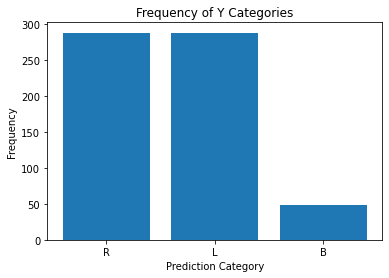

In [3]:
counts = collections.Counter(df['B'])
plt.bar(range(len(counts)), list(counts.values()), tick_label=list(counts.keys()))

plt.xlabel("Prediction Category")
plt.ylabel("Frequency")
plt.title("Frequency of Y Categories")

# Data Modification

In order to stay consistent with the credit card fraud detection example that was stated earlier in the tutorial, we will be slightly modifying the dataset to fit the metaphor. To start, the columns will be renamed for better readability. We will now be predicting Y from the features X1, X2, X3, and X4. The values for each of the features will stay the same, however the values for the Y column will be filled with "Fraudulent" if the original value was "B" and with "Non-fraudulent" if the value was not "B". Each row in the dataset should be considered one credit card transaction. The goal for our classification model will be to minimize the costs associated with improperly identifying a transaction.

In [4]:
df.rename(columns={"B": "Y", "1": "X1", "1.1": "X2", "1.2": "X3", "1.3": "X4"}, inplace = True)

modified_y_vals = []

# Iterate over rows and modify "B" to "Fraudulent" and all other to "Non-fraudulent"
for index, row in df.iterrows():
    y_val = row['Y']
    if y_val == "B":
        modified_y_vals.append("Fraudulent")
    else:
        modified_y_vals.append("Non-fraudulent")

# Replacing original Y column with new credit card terms
df['Y'] = modified_y_vals
df

,Y,X1,X2,X3,X4
0,Non-fraudulent,1,1,1,2
1,Non-fraudulent,1,1,1,3
2,Non-fraudulent,1,1,1,4
3,Non-fraudulent,1,1,1,5
4,Non-fraudulent,1,1,2,1
...,...,...,...,...,...
619,Non-fraudulent,5,5,5,1
620,Non-fraudulent,5,5,5,2
621,Non-fraudulent,5,5,5,3
622,Non-fraudulent,5,5,5,4


# Train-Test Split and Visualizing Imbalance in Train Data

After performing an 80-20 train test split on the dataset, we can very obviously see that there is a major classification imbalance in the training data. This can be a cause for concern when we build our classification models.

In [5]:
X = df.drop(columns=['Y'])
Y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

Text(0.5, 1.0, 'Frequency of Y Categories')

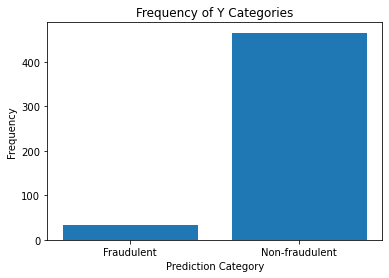

In [6]:
counts = collections.Counter(y_train)
plt.bar(range(len(counts)), list(counts.values()), tick_label=list(counts.keys()))

plt.xlabel("Prediction Category")
plt.ylabel("Frequency")
plt.title("Frequency of Y Categories on Train Data")

# Unbalanced Classification Model

At a first glance, our models seem to be performing very well. When training a vanilla logistic regression, our train accuracy is over 93% and our test accuracy is exactly 88%. However, given how unbalanced our training data was, it is important to be skeptical about why these accuracies are so high. Further examination is necessary.

In [7]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

train_accuracy = logistic_model.score(X_train, y_train)
test_accuracy = logistic_model.score(X_test, y_test)

print("Train accuracy: " + str(train_accuracy))
print("Test accuracy: " + str(test_accuracy))

Train accuracy: 0.9338677354709419
Test accuracy: 0.88


When you create the confusion matrix for both the train and test data, it becomes very obvious why the accuracies were so high. The model would predict all transactions to be non-fraudulent. Since very few transactions in the dataset are fraudulent, always guessing non-fraudulent would result in high accuracy. For the credit card company, however, this type of behavior is obviously unacceptable. The cost of having a fraudulent transaction be classified as non-fraudulent is enormous.

The model predicted fraud 0 times on train data
The model predicted no fraud 499 times on train data


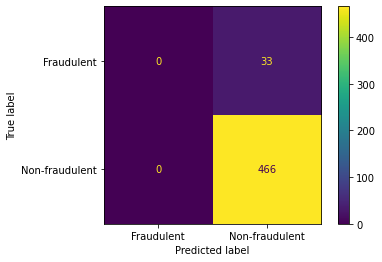

In [8]:
plot_confusion_matrix(logistic_model, X_train, y_train)

train_pred = logistic_model.predict(X_train)
num_times_guessed_fraud = np.sum(train_pred == "Fraudulent")
num_times_guessed_no_fraud = np.sum(train_pred == "Non-fraudulent")

print("The model predicted fraud " + str(num_times_guessed_fraud) + " times on train data")
print("The model predicted no fraud " + str(num_times_guessed_no_fraud) + " times on train data")

The model predicted fraud 0 times on test data
The model predicted no fraud 125 times on test data


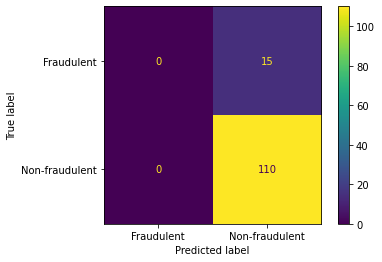

In [9]:
plot_confusion_matrix(logistic_model, X_test, y_test)

test_pred = logistic_model.predict(X_test)
num_times_guessed_fraud = np.sum(test_pred == "Fraudulent")
num_times_guessed_no_fraud = np.sum(test_pred == "Non-fraudulent")

print("The model predicted fraud " + str(num_times_guessed_fraud) + " times on test data")
print("The model predicted no fraud " + str(num_times_guessed_no_fraud) + " times on test data")

When examining AUC scores on the train and test data sets, we find them to be extremely low. In fact, the test data AUC score is less than 0.5, which indicates it is performing worse than guessing randomly between the two classes.

In [10]:
auc_train = roc_auc_score(y_train, logistic_model.decision_function(X_train))
auc_test = roc_auc_score(y_test, logistic_model.decision_function(X_test))

print("Train AUC: " + str(auc_train))
print("Test AUC: " + str(auc_test))

Train AUC: 0.5314085056574326
Test AUC: 0.4096969696969697


# Introduction of New Metric: Misclassification Cost

In order for a metric to better fit this scenario, it would need to take into the account that one type of misclassification is much costlier than another type of misclassification. The function for misclassification cost defined below.

In [11]:
def misclassification_cost(y_true, y_pred, cost_of_fraud, cost_of_false_accusation):
    # Use confusion matrix function to find wrongly classified transactions
    _, num_fraud, num_false_accusation, _ = confusion_matrix(y_true, y_pred).ravel()

    fraud_costs = num_fraud * cost_of_fraud
    non_fraud_costs = num_false_accusation * cost_of_false_accusation
    
    return fraud_costs + non_fraud_costs

Given that allowing credit card fraud to occur can be financially crippling for the individual involved and extremely damaging for the company itself, the remainder of the tutorial will run under the assumption that the cost of allowing fraud to occur is ten times greater than the cost of falsely labeling a transaction as fraudulent. 

In [12]:
cost_of_fraud = 10
cost_of_false_accusation = 1

The testing misclassification cost of a model trained on unbalanced data is 150 units of cost when the costs of each misclassification are defined as above. After balancing the train data, we hope to reduce the misclassification cost.

In [13]:
unbalanced_misclass_cost = misclassification_cost(y_test, test_pred, cost_of_fraud, cost_of_false_accusation)
print("Unbalanced misclassification cost: " + str(unbalanced_misclass_cost))

Unbalanced misclassification cost: 150


# Balanced Classification Model

In order to balance imbalanced data, there are two sampling main methods of doing so: oversampling and undersampling.

Oversampling is a technique in which you duplicate instances of minority class until there is equal representation in both groups. Undersampling is a technique in which you eliminate instances of the majority class until there is equal representation in both groups.

The main drawback for oversampling is that the duplicated rows become overrepresented in the training process and the model would unfairly overfit this duplicated data. The drawback of undersampling, on the other hand, would be the loss of information from discarding a significant amount of training data.

One technique to avoid these issues would be using the ADASYN (Adaptive Synthetic) algorithm on the initial training data. This algorithm will create synthetic data that is not a direct copy of existing rows. Therefore, we will not have the issue of overrepresenting data points that we would get in a typical oversampling technique.

Details about how the ADASYN algorithm generates synthetic data are linked at the bottom of the tutorial.

In the imbalanced-learn package, ADASYN resampling is done by creating an ADASYN object and then calling the `fit_resample` method on the desired data.

In [14]:
resampler = ADASYN(random_state = 1)

X_train, y_train = resampler.fit_resample(X_train, y_train)

After resampling, the minority and majority classes are now equally represented. 

Text(0.5, 1.0, 'Frequency of Y Categories')

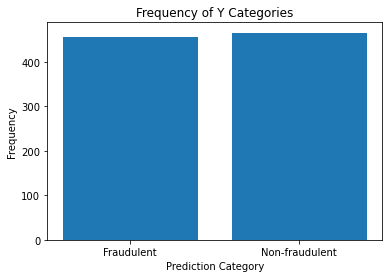

In [15]:
counts = collections.Counter(y_train)
plt.bar(range(len(counts)), list(counts.values()), tick_label=list(counts.keys()))

plt.xlabel("Prediction Category")
plt.ylabel("Frequency")
plt.title("Frequency of Y Categories")

With the newly sampled data, both our train and test accuracy fall dramatically by running the same logistic regression. This may seem concerning, but it is important to keep in mind that our most important metric is misclassification cost.

In [16]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

train_accuracy = logistic_model.score(X_train, y_train)
test_accuracy = logistic_model.score(X_test, y_test)

print("Train accuracy: " + str(train_accuracy))
print("Test accuracy: " + str(test_accuracy))

Train accuracy: 0.5661605206073753
Test accuracy: 0.616


Immediately we can see how our new model is no longer guessing "Non-fraudulent" every single time. Attempting to catch fraudulent transactions is far more desirable than passing every single transaction as non-fraudulent.

The model predicted fraud 424 times on train data
The model predicted no fraud 498 times on train data


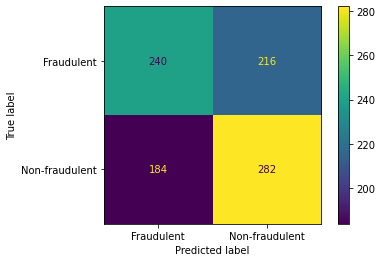

In [17]:
plot_confusion_matrix(logistic_model, X_train, y_train)

train_pred = logistic_model.predict(X_train)
num_times_guessed_fraud = np.sum(train_pred == "Fraudulent")
num_times_guessed_no_fraud = np.sum(train_pred == "Non-fraudulent")

print("The model predicted fraud " + str(num_times_guessed_fraud) + " times on train data")
print("The model predicted no fraud " + str(num_times_guessed_no_fraud) + " times on train data")

The model predicted fraud 51 times on test data
The model predicted no fraud 74 times on test data


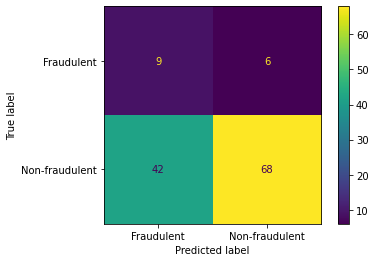

In [18]:
plot_confusion_matrix(logistic_model, X_test, y_test)

test_pred = logistic_model.predict(X_test)
num_times_guessed_fraud = np.sum(test_pred == "Fraudulent")
num_times_guessed_no_fraud = np.sum(test_pred == "Non-fraudulent")

print("The model predicted fraud " + str(num_times_guessed_fraud) + " times on test data")
print("The model predicted no fraud " + str(num_times_guessed_no_fraud) + " times on test data")

The rise in both train and test AUC scores further indicates that the model's classification performance has improved as compared to before resampling the training data.

In [19]:
auc_train = roc_auc_score(y_train, logistic_model.decision_function(X_train))
auc_test = roc_auc_score(y_test, logistic_model.decision_function(X_test))

print("Train AUC: " + str(auc_train))
print("Test AUC: " + str(auc_test))

Train AUC: 0.5920111437391763
Test AUC: 0.5709090909090909


Finally, we can see that the total misclassification cost with the same cost for missing fraudulent activity and for falsely tagging a legitimate transaction as fraudulent (10 and 1 respectively) is only 102 units of cost when the training data is resampled with the ADASYN algorithm. This 102 units of cost is significantly lower than the above 150 units of cost when the training data is not resampled.

In [20]:
balanced_misclass_cost = misclassification_cost(y_test, test_pred, cost_of_fraud, cost_of_false_accusation)
print("Balanced misclassification cost: " + str(balanced_misclass_cost))

Balanced misclassification cost: 102


# Summary

This tutorial covered the impact that training classification models on imbalanced data can have and how to improve model performance when pure error is not an appropriate performance metric. Only one algorithm was covered and much more information about the imbalanced-learn package, ADASYN algorithm, and other resampling algorithms can be found at the links below.

# Notes and Assumptions Made
- All function calls that involve elements of randomization were given a seed for reproducibility of numbers.
- The costs associated with misclassification were mere estimates and more research would need to be conducted to understand the impact of misclassifying credit card fraud.
- Other resampling algorithms could be used in this case to improve misclassification cost. ADASYN is not necessarily the optimal algorithm for all situations. Information for other algorithms are linked below.
- A logistic regression was used to simplify the explanation of dealing with data imbalance. Other classification algorithms may have worked better in detecting credit card fraud.

# References/Additional Resources

- imbalanced-learn documentation: https://imbalanced-learn.org/stable/references/index.html#api
- ADASYN algorithm : https://medium.com/@ruinian/an-introduction-to-adasyn-with-code-1383a5ece7aa
- Other resampling algorithms: https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/